In [75]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
import pandas as pd
from tbcontrol.symbolic import routh

In [76]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [77]:
s = ctl.TransferFunction.s
G = 97123.0366515921/(1.0*s**2 + 684974.722594433*s - 1324231.64800177)

G_bkp = G
G

TransferFunction(array([97123.03665159]), array([ 1.00000000e+00,  6.84974723e+05, -1.32423165e+06]))

polos:  (-684976.656+0j) (1.933+0j)
zeros: 


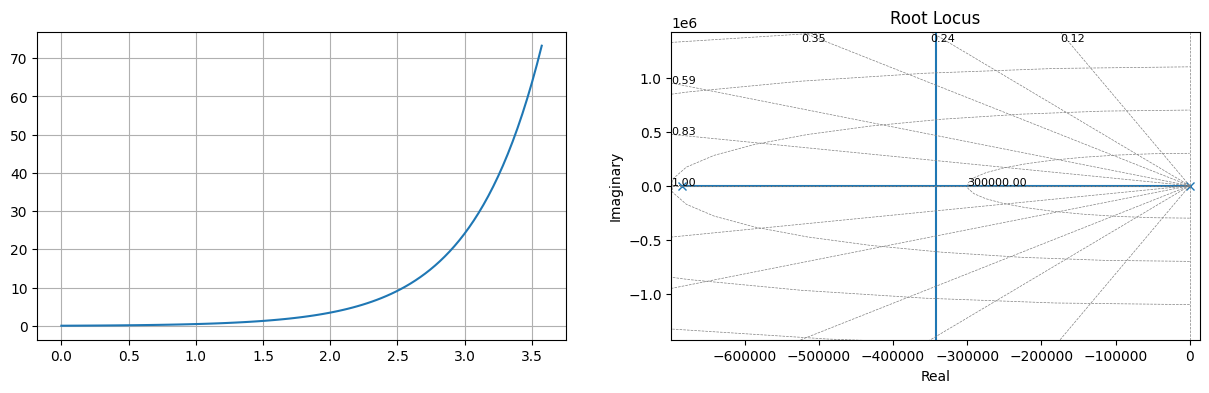

In [78]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)

plt.show()

# INFORMAÇÕES DA RESPOSTA

In [79]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, show=False)

{'overshoot': 0.0,
 'peakValue': 73.26938579219375,
 'peakTime': 3.57312945777589,
 'settlingTime': None,
 'finalValue': 73.26938579219375,
 'error': 72.26938579219375}

# CONTROLADOR
- Encontrando as constantes do controlador: $C(s) = K_p \, \big(1 + \frac{1}{T_is}\big)\big(\frac{T_ds + 1}{0.1T_ds + 1}\big)$

In [80]:
s = ctl.TransferFunction.s

In [81]:
def getResponsePID(Kp, Ti, Td):
    C = Kp * (1 + 1/(Ti*s)) * (Td*s + 1) / (0.1*Td*s + 1)
    G_feedback = ctl.feedback(G*C, 1)

    time, response = ctl.step_response(G_feedback)
    data = getAllInfo(time, response, show=False)

    if data.get('settlingTime') is None:
        return None
    
    data['Kp'] = Kp
    data['Ti'] = Ti
    data['Td'] = Td
    return data

getResponsePID(1, 1, 1)

In [82]:
Kp_data = np.linspace(0.01, 100, 10)
Ti_data = np.linspace(0.01, 5, 10)
Td_data = np.linspace(0.01, 5, 10)

In [83]:
data = []

for Kp in Kp_data:
    for Ti in Ti_data:
        for Td in Td_data:
            response = getResponsePID(Kp, Ti, Td)

            if response is None:
                continue
            
            data.append(response)

c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\control\timeresp.py:1054: RuntimeWarning: overflow encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\control\timeresp.py:1054: RuntimeWarning: invalid value encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\control\timeresp.py:1056: RuntimeWarning: overflow encountered in matmul
  yout = C @ xout + D @ U
c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\linalg\_matfuncs.py:358: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\linalg\_matfuncs.py:358: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


In [84]:
def displayLimits(df):
    display(df.head())
    print('settlingTime: ', (df.settlingTime.min().round(3), df.settlingTime.max().round(3)))
    print('overshoot:    ', (df.overshoot.min().round(3), df.overshoot.max().round(3)))
    print('error:        ', (df.error.min().round(3), df.error.max().round(3)))


df = pd.DataFrame(data)
displayLimits(df)

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
0,0.345897,1.345897,0.074961,0.374803,1.0,5.048184e-13,11.12,0.01,0.564444
1,0.009021,1.009021,0.609294,0.304647,1.0,3.793632e-13,11.12,0.01,1.118889
2,0.106941,1.106941,0.228256,0.456513,1.0,1.142197e-12,11.12,0.01,1.673333
3,0.004230,1.004230,0.917673,0.611782,1.0,1.560752e-12,11.12,0.01,2.227778
4,0.032139,1.032139,0.381039,0.762078,1.0,2.888800e-12,11.12,0.01,2.782222


settlingTime:  (0.025, 11.701)
overshoot:     (0.0, 0.594)
error:         (0.0, 0.528)


### ANÁLISE DOS DADOS

In [85]:
df = df.loc[(df.settlingTime > 1.0) & (df.settlingTime < 10.0)]
displayLimits(df)

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
9,0.004039,1.449647,1.439944,1.115001,1.443815,0.443815,11.12,0.564444,1.118889
12,0.215097,1.216545,1.312519,6.422591,1.001191,0.001191,11.12,0.564444,2.782222
13,0.186394,1.186935,1.226720,7.406091,1.000456,0.000456,11.12,0.564444,3.336667
14,0.165714,1.166072,1.098486,8.210236,1.000307,0.000307,11.12,0.564444,3.891111
15,0.151434,1.151706,0.914128,8.898162,1.000236,0.000236,11.12,0.564444,4.445556


settlingTime:  (1.115, 9.995)
overshoot:     (0.0, 0.59)
error:         (0.0, 0.528)


In [86]:
df = df.loc[(df.overshoot > 0.0) & (df.overshoot < 0.1)]
displayLimits(df)

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
9,0.004039,1.449647,1.439944,1.115001,1.443815,0.443815,11.12,0.564444,1.118889
21,0.000006,1.280415,2.200118,1.383945,1.280408,0.280408,11.12,1.118889,3.891111
22,0.000170,1.251367,2.177908,1.306745,1.251154,0.251154,11.12,1.118889,4.445556
46,0.098653,1.098911,1.174911,5.605119,1.000235,0.000235,22.23,0.564444,2.782222
47,0.085931,1.086107,1.108279,6.018946,1.000162,0.000162,22.23,0.564444,3.336667


settlingTime:  (1.115, 9.995)
overshoot:     (0.0, 0.099)
error:         (0.0, 0.444)


In [87]:
df = df.loc[(df.error > 0.0) & (df.error < 0.05)]
displayLimits(df)

,overshoot,peakValue,peakTime,settlingTime,finalValue,error,Kp,Ti,Td
46,0.098653,1.098911,1.174911,5.605119,1.000235,0.000235,22.23,0.564444,2.782222
47,0.085931,1.086107,1.108279,6.018946,1.000162,0.000162,22.23,0.564444,3.336667
48,0.076877,1.077011,1.001936,6.323225,1.000125,0.000125,22.23,0.564444,3.891111
115,0.092282,1.094016,1.151279,3.935637,1.001587,0.001587,33.34,0.564444,1.673333
116,0.075552,1.075794,1.160821,4.432488,1.000225,0.000225,33.34,0.564444,2.227778


settlingTime:  (2.265, 9.995)
overshoot:     (0.03, 0.099)
error:         (0.0, 0.002)


In [88]:
row = df.iloc[0].to_dict()
Kp, Ti, Td = row['Kp'], row['Ti'], row['Td']
Kp, Ti, Td

(22.23, 0.5644444444444445, 2.7822222222222224)

# RESPOSTA CONTROLADA

In [89]:
s  = ctl.TransferFunction.s

C = Kp * (1 + 1/(Ti*s)) * (Td*s + 1) / (0.1*Td*s + 1)
print(sympyFunction(C))
C

(34.9102115555556*s**2 + 74.3964*s + 22.23)/(0.157040987654321*s**2 + 0.564444444444445*s)


TransferFunction(array([34.91021156, 74.3964    , 22.23      ]), array([0.15704099, 0.56444444, 0.        ]))

In [90]:
G = G_bkp

G_ma = G*C
G_ma

TransferFunction(array([3390585.75642506, 7225604.28394651, 2159045.10476489]), array([ 1.57040988e-01,  1.07569671e+05,  1.78671531e+05, -7.47455197e+05,
        0.00000000e+00]))

In [91]:
G_feedback = ctl.feedback(G_ma, 1)
G_feedback

TransferFunction(array([3390585.75642506, 7225604.28394651, 2159045.10476489]), array([1.57040988e-01, 1.07569671e+05, 3.56925729e+06, 6.47814909e+06,
       2.15904510e+06]))

- Como todos os polos do sistema em malha fechada estão no semiplano esquerdo, o sistema é estável

In [92]:
[np.round(val, 3) for val in list(ctl.poles(G_feedback))]

[(-684945.134+0j), (-31.277+0j), (-1.468+0j), (-0.437+0j)]

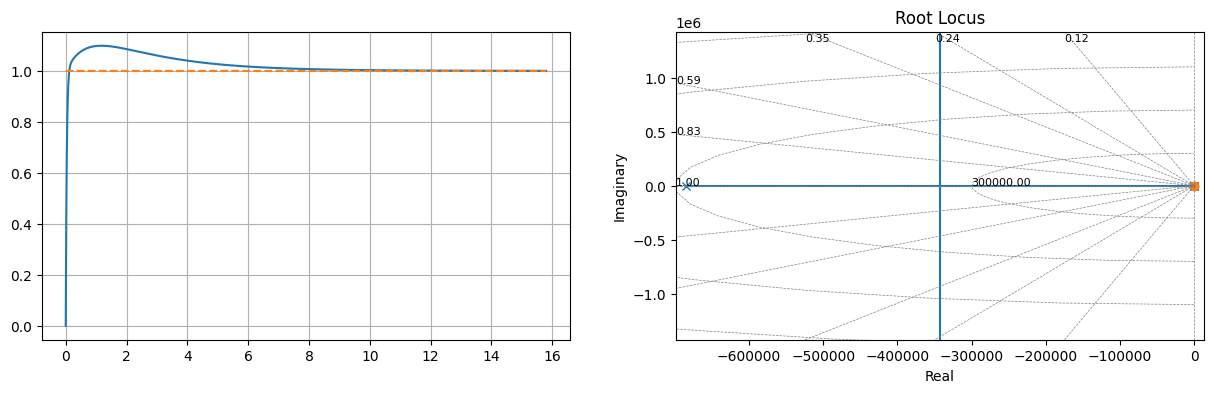

In [93]:
time, response = ctl.step_response(G_feedback)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.plot(time, [1 for i in time], '--')
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G_ma)
plt.show()

In [94]:
getAllInfo(time, response, setpoint=1)

overshoot:  0.09865271753089329
valor de pico:  1.0989114146569867
tempo de pico:  1.174910592273048
tempo de assentamento:  5.605118577422925
valor final:  1.0002354676067928
erro:  0.0002354676067928274


# APLICANDO VÁRIOS STEPS

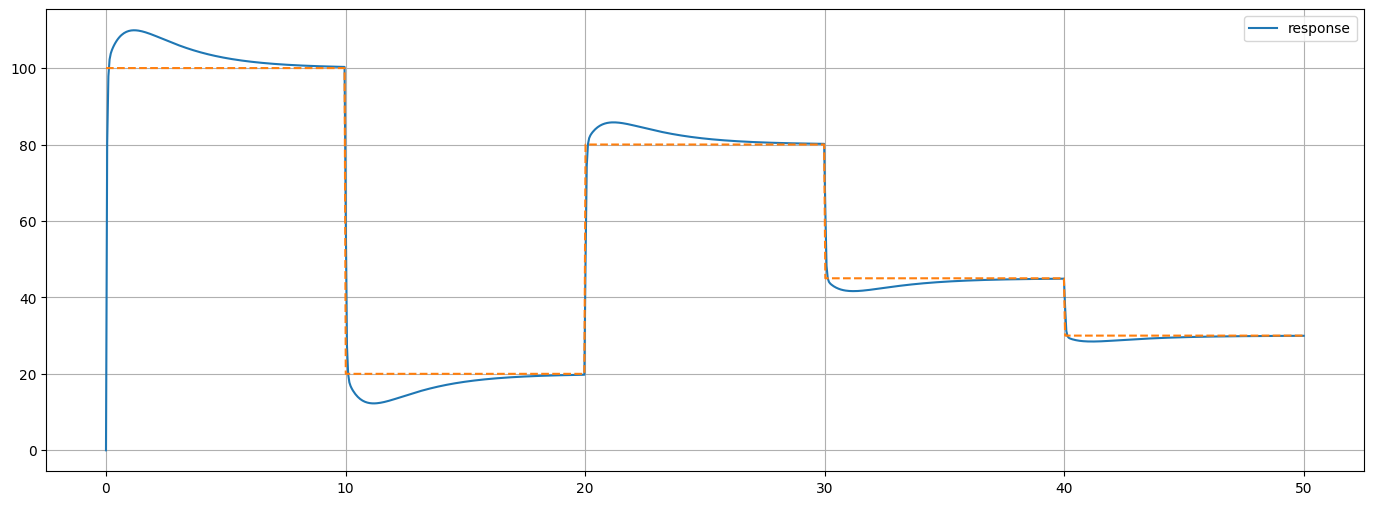

In [95]:
def makeSteps(stepList, length):
    stepSize = length // len(stepList)
    array = []

    for step in stepList:
        array = array + list(step * np.ones(stepSize))

    sizeLeft = len(array) - length

    if sizeLeft > 0:
        array = array + list(stepList[-1] * np.ones(sizeLeft))

    return array


tData = np.linspace(0, 50, 1000)
uData = makeSteps([100, 20, 80, 45, 30], len(tData))

plt.figure(figsize=(17, 6))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.plot(time, uData, '--')
plt.legend()
plt.grid()